# Supervised Learning

## Regression
In this Notebook we will examine bitcoin prices and see if we can predict the value.

https://www.kaggle.com/mczielinski/bitcoin-historical-data/data

Data under CC BY-SA 4.0 License

https://www.kaggle.com/mczielinski/bitcoin-historical-data

In [88]:
%matplotlib inline
    
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import ensemble, linear_model, model_selection, preprocessing, svm
from sklearn import metrics 
from yellowbrick import regressor 

In [4]:
 %%time
# Resampling data from minute interval to day
bit_df = pd.read_csv('../data/coinbaseUSD_1-min_data_2014-12-01_to_2018-01-08.csv')
# Convert unix time to datetime
bit_df['date'] = pd.to_datetime(bit_df.Timestamp, unit='s')
# Reset index
bit_df = bit_df.set_index('date')
# Rename columns so easier to code
bit_df = bit_df.rename(columns={'Open':'open', 'High': 'hi', 'Low': 'lo', 
                       'Close': 'close', 'Volume_(BTC)': 'vol_btc',
                       'Volume_(Currency)': 'vol_cur', 
                       'Weighted_Price': 'wp', 'Timestamp': 'ts'})
# Resample and only use recent samples that aren't missing
bit_df = bit_df.resample('d').agg({'open': 'first', 'hi': 'max', 
    'lo': 'min', 'close': 'last', 'vol_btc': 'sum',
    'vol_cur': 'sum', 'wp': 'mean', 'ts': 'min'}).iloc[-1000:]
# drop last row as it is not complete
bit_df = bit_df.iloc[:-1]

CPU times: user 1.22 s, sys: 469 ms, total: 1.69 s
Wall time: 1.69 s


In [5]:
 bit_df

,open,hi,lo,close,vol_btc,vol_cur,wp,ts
date,,,,,,,,
2015-04-15,221.05,224.52,218.09,224.35,9137.584626,2.029524e+06,222.270771,1.429056e+09
2015-04-16,224.35,230.75,223.66,229.45,8636.837666,1.970069e+06,227.779413,1.429142e+09
2015-04-17,229.45,230.08,220.46,223.62,7738.360003,1.741497e+06,224.970863,1.429229e+09
2015-04-18,223.55,224.04,222.18,224.02,5065.649127,1.131269e+06,223.398170,1.429315e+09
2015-04-19,224.02,226.72,223.44,224.03,5279.787312,1.185860e+06,224.667792,1.429402e+09
...,...,...,...,...,...,...,...,...
2018-01-03,14781.52,15400.00,14628.00,15098.14,17616.327677,2.642264e+08,14989.939350,1.514938e+09
2018-01-04,15098.23,15400.00,14230.00,15144.99,19567.016783,2.909045e+08,14851.477880,1.515024e+09
2018-01-05,15145.00,17178.00,14819.78,16960.01,22588.046307,3.619888e+08,15796.596968,1.515110e+09


In [6]:
bit_df.dtypes

open       float64
hi         float64
lo         float64
close      float64
vol_btc    float64
vol_cur    float64
wp         float64
ts         float64
dtype: object

In [7]:
bit_df.describe()

,open,hi,lo,close,vol_btc,vol_cur,wp,ts
count,999.00000,999.000000,999.000000,999.000000,999.000000,9.990000e+02,999.000000,9.990000e+02
mean,1838.11015,1914.705946,1757.861101,1854.054895,10350.019927,3.553735e+07,1842.224578,1.472170e+09
std,3169.30283,3346.396825,2966.458499,3201.173766,9947.604406,1.097365e+08,3165.632076,2.492906e+07
min,211.16000,224.040000,0.060000,211.160000,1525.187302,7.925465e+05,215.969046,1.429056e+09
25%,384.61500,393.500000,371.300000,384.850000,5320.152105,2.297687e+06,384.227045,1.450613e+09
50%,629.79000,639.850000,618.130000,630.830000,7367.614526,3.484114e+06,632.673702,1.472170e+09
75%,1454.14500,1512.965000,1440.095000,1502.495000,11954.181722,1.985804e+07,1471.613323,1.493726e+09
max,19650.02000,19891.990000,19010.000000,19650.010000,165763.024424,1.393385e+09,19537.276941,1.515283e+09


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


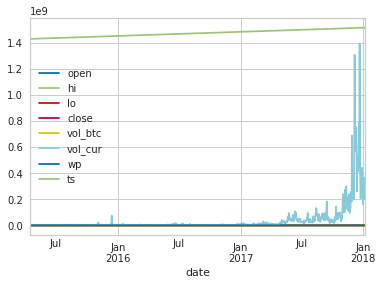

In [8]:
 bit_df.plot(figsize=(6,4))

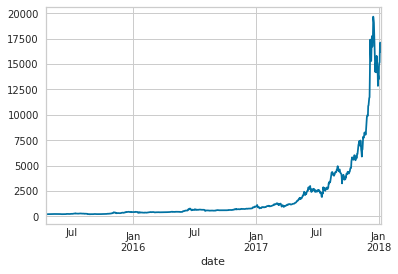

In [9]:
 bit_df.close.plot(figsize=(6,4))

### Can we predict tomorrow's close based on today's info?
We will use a row of data for input. 

We will call the input X and the prediction y. This is called "supervised learning" as we will feed in both X and y to train the model.

Let's use a model called Linear Regression. This performs better if we standardize the data (0 mean, 1 std).

For 2 dimensions this takes the form of 

\begin{align}y = m*x + b\end{align}

M is the slope (or coefficient) and b is the intercept.

Let's see if we can predict the open price from the ts component.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


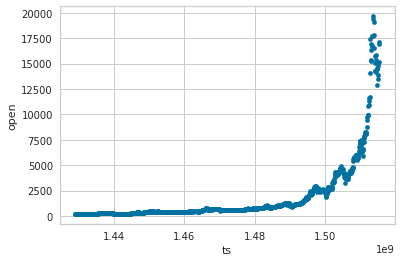

In [10]:
bit_df.plot(kind='scatter', x='ts', y='open', figsize=(6,4)) 

In [12]:
 # Create our input (X) and our labelled data (y) to train our model
X = bit_df[['ts']].iloc[:-1]  # drop last row because we don't know what future is
y = bit_df.close.shift(-1).iloc[:-1]

In [13]:
 # Train a model and predict output if it were given X
lr_model = linear_model.LinearRegression()
lr_model.fit(X, y)
pred = lr_model.predict(X)

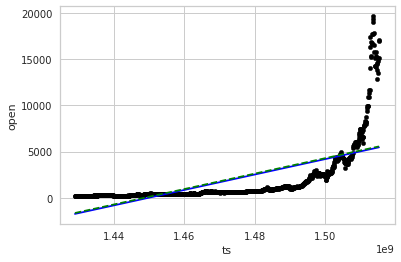

In [15]:
 # Plot the real data, our prediction (blue), and the model from the coeffictient (green shifted)
ax = bit_df.plot(kind='scatter', x='ts', y='open', color='black', figsize=(6,4))
ax.plot(X, pred, color='blue')  # matplotlib plot
ax.plot(X, X*lr_model.coef_ + lr_model.intercept_+ 100, linestyle='--', color='green')

In [16]:
 # Vertical distance between line and point is the error. *Ordinary Least Squares* 
# regression tries to minimize the square of the distance.
mean_squared_error(y, pred) 

5905906.764562201

In [17]:
 # Vertical distance between line and point is the error. *Ordinary Least Squares* 
# regression tries to minimize the square of the distance.
mean_squared_error(y, pred) 

5905906.764562201

### Lab Data
 
This exercise looks at predicting the size of forest fires based on meteorological data 
https://archive.ics.uci.edu/ml/datasets/Forest+Fires

The file is in ../data/forestfires.csv

* Read the data into a DataFrame
* Examine the types
* Describe the data

Attribute information:   For more information, read [Cortez and Morais, 2007].

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec" 
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3 
7. DC - DC index from the FWI system: 7.9 to 860.6 
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 (this output variable is very skewed towards 0.0, thus it may make
sense to model with the logarithm transform).

In [19]:
ff = pd.read_csv('../data/forestfires.csv') 

In [20]:
ff.dtypes 

X          int64
Y          int64
month     object
day       object
FFMC     float64
DMC      float64
DC       float64
ISI      float64
temp     float64
RH         int64
wind     float64
rain     float64
area     float64
dtype: object

In [21]:
ff.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


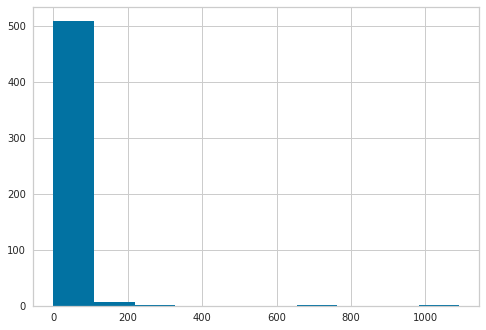

In [22]:
ff.area.hist() 

## Regression Exercise

* Use linear regression to predict area from the other columns. (If you have object data columns, you can create dummy columns using `pd.get_dummies`, `pd.concat`, and `pd.drop`)
* What is your score?

In [23]:
ff.dtypes 

X          int64
Y          int64
month     object
day       object
FFMC     float64
DMC      float64
DC       float64
ISI      float64
temp     float64
RH         int64
wind     float64
rain     float64
area     float64
dtype: object

In [24]:
yff = ff.area
ff2 = (
    pd.concat([ff, pd.get_dummies(ff.month),
              pd.get_dummies(ff.day)], axis=1)
    .drop(['month', 'day', 'area'], axis=1)
)
Xff = ff2

In [25]:
ff_lr = linear_model.LinearRegression()
ff_lr.fit(Xff, yff)
ff_lr.score(Xff, yff)

0.0457820965080854

In [26]:
 # try log area import numpy as np
def log(x):
    return np.log(x+1)
ff_lr2 = linear_model.LinearRegression()
ff_lr2.fit(Xff, log(yff))
ff_lr2.score(Xff, log(yff))

0.07425967860549865

### Regression Evaluation

In [28]:
# Use more columns
# drop last row because we don't know what future is

X = (bit_df
         .drop(['close'], axis=1)
         .iloc[:-1])
y = bit_df.close.shift(-1).iloc[:-1]
cols = X.columns

# We are going to scale the data so that volume and ts don't get more
# weight that other values
ss = preprocessing.StandardScaler()
ss.fit(X)
X = ss.transform(X)
X = pd.DataFrame(X, columns=cols)

X_train, X_test, y_train, y_test = model_selection.\
    train_test_split(X, y, test_size=.3, random_state=42)

In [29]:
# We can now see that the data has a mean close to 0
# and a std of 1
X.describe()

,open,hi,lo,vol_btc,vol_cur,wp,ts
count,9.980000e+02,998.000000,9.980000e+02,9.980000e+02,998.000000,9.980000e+02,9.980000e+02
mean,-5.695733e-17,0.000000,-5.695733e-17,9.967533e-17,0.000000,-5.695733e-17,-5.695733e-17
std,1.000501e+00,1.000501,1.000501e+00,1.000501e+00,1.000501,1.000501e+00,1.000501e+00
min,-5.145398e-01,-0.505931,-5.945063e-01,-8.869604e-01,-0.315473,-5.146584e-01,-1.730316e+00
25%,-4.591903e-01,-0.454985,-4.679614e-01,-5.056673e-01,-0.301741,-4.609381e-01,-8.651581e-01
50%,-3.811430e-01,-0.380665,-3.838863e-01,-2.998543e-01,-0.290954,-3.816854e-01,0.000000e+00
75%,-1.274829e-01,-0.124745,-1.129190e-01,1.545122e-01,-0.144161,-1.198984e-01,8.651581e-01
max,5.691531e+00,5.433195,5.886561e+00,1.562362e+01,12.389219,5.655753e+00,1.730316e+00


In [31]:
lr_model2 = linear_model.LinearRegression()
lr_model2.fit(X_train, y_train)
lr_model2.score(X_test, y_test)

0.9949690637286265

In [34]:
metrics.r2_score(y_test, lr_model2.predict(X_test))

0.9949690637286265

In [35]:
metrics.mean_squared_error(y_test, lr_model2.predict(X_test))

48633.87889223455

In [36]:
metrics.mean_absolute_error(y_test, lr_model2.predict(X_test))

72.45942732345566

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


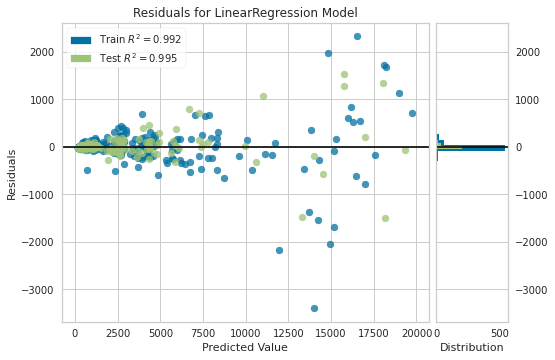

/home/matt/.envs/env36/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


ResidualsPlot(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f3595e9fda0>,
              hist=True, is_fitted='auto', line_color=None, model=None,
              test_alpha=None, test_color=None, train_alpha=None,
              train_color=None)

In [32]:
regressor.residuals_plot(lr_model2, X_train, y_train,X_test, y_test )

## Regression Evaluation Exercise

Using the forest fire data set

* Evaluate the performance of your model with the R2 and MSE score (remember to split your data)
* Plot a residuals plot

In [37]:
Xff_train, Xff_test, yff_train, yff_test = model_selection.\
    train_test_split(Xff, yff, test_size=.3, random_state=42)

ff_lr = linear_model.LinearRegression()
ff_lr.fit(Xff_train, yff_train)
ff_lr.score(Xff_test, yff_test)

0.01601313186526032

In [38]:
metrics.r2_score(yff_test, ff_lr.predict(Xff_test))

0.01601313186526032

In [39]:
metrics.mean_squared_error(yff_test, ff_lr.predict(Xff_test))

7830.489034285373

In [40]:
metrics.mean_absolute_error(yff_test, ff_lr.predict(Xff_test))

20.853980923810184

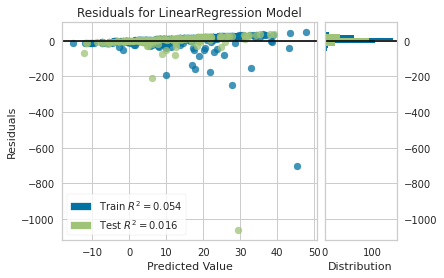

/home/matt/.envs/env36/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


ResidualsPlot(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f3595373eb8>,
              hist=True, is_fitted='auto', line_color=None, model=None,
              test_alpha=None, test_color=None, train_alpha=None,
              train_color=None)

In [42]:
regressor.residuals_plot(ff_lr, Xff_train, yff_train, Xff_test, yff_test )

## Classification

 
In this Notebook we will examine bitcoin data and see if we can predict a buy or sell.

https://www.kaggle.com/mczielinski/bitcoin-historical-data/data

Data under CC BY-SA 4.0 License

https://www.kaggle.com/mczielinski/bitcoin-historical-data

In [71]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import ensemble, model_selection, preprocessing, tree
from yellowbrick import classifier


In [44]:
%%time
# Resampling data from minute interval to day
bit_df = pd.read_csv('../data/coinbaseUSD_1-min_data_2014-12-01_to_2018-01-08.csv')
# Convert unix time to datetime
bit_df['date'] = pd.to_datetime(bit_df.Timestamp, unit='s')
# Reset index
bit_df = bit_df.set_index('date')
# Rename columns so easier to code
bit_df = bit_df.rename(columns={'Open':'open', 'High': 'hi', 'Low': 'lo', 
                       'Close': 'close', 'Volume_(BTC)': 'vol_btc',
                       'Volume_(Currency)': 'vol_cur', 
                       'Weighted_Price': 'wp', 'Timestamp': 'ts'})
# Resample and only use recent samples that aren't missing
bit_df = bit_df.resample('d').agg({'open': 'first', 'hi': 'max', 
    'lo': 'min', 'close': 'last', 'vol_btc': 'sum',
    'vol_cur': 'sum', 'wp': 'mean', 'ts': 'min'}).iloc[-1000:]
bit_df['buy'] = (bit_df.close.shift(-1) > bit_df.close).astype(int)
# drop last row as it is not complete
bit_df = bit_df.iloc[:-1]

CPU times: user 1.88 s, sys: 375 ms, total: 2.25 s
Wall time: 2.25 s


In [45]:
bit_df

,open,hi,lo,close,vol_btc,vol_cur,wp,ts,buy
date,,,,,,,,,
2015-04-15,221.05,224.52,218.09,224.35,9137.584626,2.029524e+06,222.270771,1.429056e+09,1
2015-04-16,224.35,230.75,223.66,229.45,8636.837666,1.970069e+06,227.779413,1.429142e+09,0
2015-04-17,229.45,230.08,220.46,223.62,7738.360003,1.741497e+06,224.970863,1.429229e+09,1
2015-04-18,223.55,224.04,222.18,224.02,5065.649127,1.131269e+06,223.398170,1.429315e+09,1
2015-04-19,224.02,226.72,223.44,224.03,5279.787312,1.185860e+06,224.667792,1.429402e+09,1
...,...,...,...,...,...,...,...,...,...
2018-01-03,14781.52,15400.00,14628.00,15098.14,17616.327677,2.642264e+08,14989.939350,1.514938e+09,1
2018-01-04,15098.23,15400.00,14230.00,15144.99,19567.016783,2.909045e+08,14851.477880,1.515024e+09,1
2018-01-05,15145.00,17178.00,14819.78,16960.01,22588.046307,3.619888e+08,15796.596968,1.515110e+09,1


In [46]:
bit_df.dtypes

open       float64
hi         float64
lo         float64
close      float64
vol_btc    float64
vol_cur    float64
wp         float64
ts         float64
buy          int64
dtype: object

In [47]:
bit_df.describe()

,open,hi,lo,close,vol_btc,vol_cur,wp,ts,buy
count,999.00000,999.000000,999.000000,999.000000,999.000000,9.990000e+02,999.000000,9.990000e+02,999.000000
mean,1838.11015,1914.705946,1757.861101,1854.054895,10350.019927,3.553735e+07,1842.224578,1.472170e+09,0.567568
std,3169.30283,3346.396825,2966.458499,3201.173766,9947.604406,1.097365e+08,3165.632076,2.492906e+07,0.495662
min,211.16000,224.040000,0.060000,211.160000,1525.187302,7.925465e+05,215.969046,1.429056e+09,0.000000
25%,384.61500,393.500000,371.300000,384.850000,5320.152105,2.297687e+06,384.227045,1.450613e+09,0.000000
50%,629.79000,639.850000,618.130000,630.830000,7367.614526,3.484114e+06,632.673702,1.472170e+09,1.000000
75%,1454.14500,1512.965000,1440.095000,1502.495000,11954.181722,1.985804e+07,1471.613323,1.493726e+09,1.000000
max,19650.02000,19891.990000,19010.000000,19650.010000,165763.024424,1.393385e+09,19537.276941,1.515283e+09,1.000000


## Decision Tree

* The process of training classifier is to get X and y and call `.fit(X, y)`
* To predict values of y (y hat), call `.predict(X)`
* To get the accuracy call `.score(X, y)`

In [68]:
ignore = {'buy'}
cols = [c for c in bit_df.columns if c not in ignore]
X = bit_df[cols]
y = bit_df.buy
X_train, X_test, y_train, y_test = model_selection.\
    train_test_split(X, y, test_size=.3, random_state=42)

In [69]:
dt_model = tree.DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
dt_model.score(X_test, y_test)

0.4866666666666667

In [50]:
dt_model.predict(X)

array([1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1,

[Text(81.38229957651869, 213.69103448275862, 'X[3] <= 225.425\ngini = 0.491\nsamples = 999\nvalue = [432, 567]'),
 Text(79.81781359521028, 206.19310344827585, 'gini = 0.0\nsamples = 13\nvalue = [0, 13]'),
 Text(82.94678555782711, 206.19310344827585, 'X[7] <= 1443441600.0\ngini = 0.492\nsamples = 986\nvalue = [432, 554]'),
 Text(30.214135514018693, 198.6951724137931, 'X[5] <= 1542237.25\ngini = 0.49\nsamples = 154\nvalue = [88, 66]'),
 Text(16.035981308411216, 191.19724137931036, 'X[0] <= 282.17\ngini = 0.496\nsamples = 55\nvalue = [25, 30]'),
 Text(14.471495327102804, 183.69931034482758, 'X[5] <= 1494430.75\ngini = 0.5\nsamples = 50\nvalue = [25, 25]'),
 Text(8.604672897196263, 176.20137931034483, 'X[5] <= 900533.25\ngini = 0.493\nsamples = 43\nvalue = [24, 19]'),
 Text(7.040186915887851, 168.70344827586206, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]'),
 Text(10.169158878504673, 168.70344827586206, 'X[1] <= 242.975\ngini = 0.485\nsamples = 41\nvalue = [24, 17]'),
 Text(6.257943925233645,

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


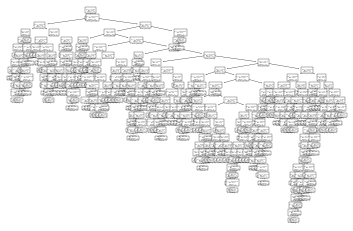

In [52]:
tree.plot_tree(dt_model)

In [64]:
 # note that this goes to a Unix path
tree.export_graphviz(dt_model, out_file='/tmp/tree1.dot', 
                     feature_names=X.columns, class_names=['Sell', 'Buy'],
                    filled=True
                    )

In [65]:
 %%bash
# This doesn't run on Windows. Also requires that you have graphviz installed (not a Python module)
dot -Tpng -otree1.png /tmp/tree1.dot

<img src="tree1.png">

### Lab Data

Mushroom data https://archive.ics.uci.edu/ml/datasets/Mushroom

data in ../data/agaricus-lepiota.data.txt

First column is class: edible=e, poisonous=p

Attribute Information:
* cap-shape: bell=b,conical=c,convex=x,flat=f, knobbed=k,sunken=s 
* cap-surface: fibrous=f,grooves=g,scaly=y,smooth=s 
* cap-color: brown=n,buff=b,cinnamon=c,gray=g,green=r,pink=p,purple=u,red=e,white=w,yellow=y 
* bruises?: bruises=t,no=f 
* odor: almond=a,anise=l,creosote=c,fishy=y,foul=f, musty=m,none=n,pungent=p,spicy=s 
* gill-attachment: attached=a,descending=d,free=f,notched=n 
* gill-spacing: close=c,crowded=w,distant=d 
* gill-size: broad=b,narrow=n 
* gill-color: black=k,brown=n,buff=b,chocolate=h,gray=g,green=r,orange=o,pink=p,purple=u,red=e, white=w,yellow=y 
* stalk-shape: enlarging=e,tapering=t 
* stalk-root: bulbous=b,club=c,cup=u,equal=e, rhizomorphs=z,rooted=r,missing=? 
* stalk-surface-above-ring: fibrous=f,scaly=y,silky=k,smooth=s 
* stalk-surface-below-ring: fibrous=f,scaly=y,silky=k,smooth=s 
* stalk-color-above-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o, pink=p,red=e,white=w,yellow=y 
* stalk-color-below-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o, pink=p,red=e,white=w,yellow=y 
* veil-type: partial=p,universal=u 
* veil-color: brown=n,orange=o,white=w,yellow=y 
* ring-number: none=n,one=o,two=t 
* ring-type: cobwebby=c,evanescent=e,flaring=f,large=l, none=n,pendant=p,sheathing=s,zone=z 
* spore-print-color: black=k,brown=n,buff=b,chocolate=h,green=r, orange=o,purple=u,white=w,yellow=y 
* population: abundant=a,clustered=c,numerous=n, scattered=s,several=v,solitary=y 
* habitat: grasses=g,leaves=l,meadows=m,paths=p, urban=u,waste=w,woods=d

In [67]:
mush_df = pd.read_csv('../data/agaricus-lepiota.data.txt',
     names='class,cap_shape,cap_surface,cap_color,bruises,'
     'odor,g_attachment,g_spacing,g_size,g_color,s_shape,'
     's_root,s_surface_a,s_surface_b,s_color_a,s_color_b,'
     'v_type,v_color,ring_num,ring_type,spore_color,pop,hab'.split(','))
mush_df = pd.get_dummies(mush_df, columns=mush_df.columns).drop(['class_e'],axis=1)

## Predict Exercise

* Create a decision tree to model whether a mushroom is poisonous. 
* What is the score?

In [70]:
mush_X = mush_df.iloc[:,1:]
mush_y = mush_df.class_p
mush_X_train, mush_X_test, mush_y_train, mush_y_test = model_selection.\
    train_test_split(mush_X, mush_y, test_size=.3, random_state=42)
mush_dt = tree.DecisionTreeClassifier()
mush_dt.fit(mush_X_train, mush_y_train)
mush_dt.score(mush_X_test, mush_y_test)

1.0

## Classification Evaluation

In [72]:
dt_model = tree.DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
dt_model.score(X_test, y_test)

0.4866666666666667

In [73]:
metrics.accuracy_score(y_test, dt_model.predict(X_test))

0.4866666666666667

In [74]:
metrics.precision_score(y_test, dt_model.predict(X_test))

0.5506329113924051

In [76]:
metrics.recall_score(y_test, dt_model.predict(X_test))

0.5117647058823529

/home/matt/.envs/env36/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


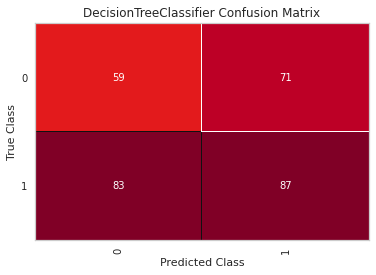

/home/matt/.envs/env36/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


ConfusionMatrix(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f35d529b748>,
                classes=None,
                cmap=<matplotlib.colors.ListedColormap object at 0x7f35d53e9b70>,
                encoder=None, fontsize=None, force_model=False,
                is_fitted='auto', model=None, percent=False,
                sample_weight=None)

In [77]:
classifier.confusion_matrix(dt_model, X_train, y_train, X_test, y_test)

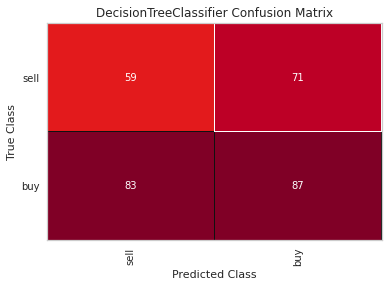

/home/matt/.envs/env36/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


ConfusionMatrix(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f3594d60d68>,
                classes=['sell', 'buy'],
                cmap=<matplotlib.colors.ListedColormap object at 0x7f35d532f2b0>,
                encoder=None, fontsize=None, force_model=False,
                is_fitted='auto', model=None, percent=False,
                sample_weight=None)

In [78]:
classifier.confusion_matrix(dt_model, X_train, y_train, X_test, y_test,
                   classes=['sell', 'buy'])

/home/matt/.envs/env36/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


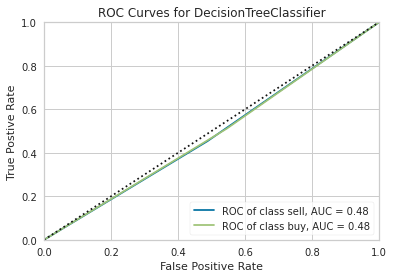

/home/matt/.envs/env36/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


ROCAUC(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f35d51b1b70>,
       classes=['sell', 'buy'], encoder=None, force_model=False,
       is_fitted='auto', macro=False, micro=False, model=None, per_class=True)

In [80]:
classifier.roc_auc(dt_model, X_train, y_train, X_test, y_test,
                   classes=['sell', 'buy'], micro=False, macro=False)

/home/matt/.envs/env36/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


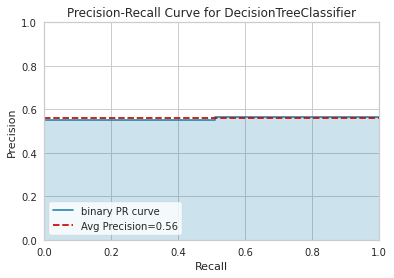

/home/matt/.envs/env36/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


PrecisionRecallCurve(ap_score=True,
                     ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f35d5119eb8>,
                     classes=['sell', 'buy'], encoder=None, fill_area=True,
                     fill_opacity=0.2, force_model=False, is_fitted='auto',
                     iso_f1_curves=False, iso_f1_values={0.2, 0.4, 0.6, 0.8},
                     line_opacity=0.8, micro=False, model=None,
                     per_class=False)

In [81]:
classifier.precision_recall_curve(dt_model, X_train, y_train, X_test, y_test,
                   classes=['sell', 'buy'], micro=False, macro=False)

## Classification Evaluation Exercise
With the mushroom dataset
* Evaluate the accuracy
* Plot a confusion matrix
* Plot an ROC 

In [82]:
mush_X = mush_df.iloc[:,1:]
mush_y = mush_df.class_p
mush_X_train, mush_X_test, mush_y_train, mush_y_test = model_selection.\
    train_test_split(mush_X, mush_y, test_size=.3, random_state=42)
mush_dt = tree.DecisionTreeClassifier()
mush_dt.fit(mush_X_train, mush_y_train)
mush_dt.score(mush_X_test, mush_y_test)

1.0

In [83]:
metrics.accuracy_score(mush_y_test, mush_dt.predict(mush_X_test))

1.0

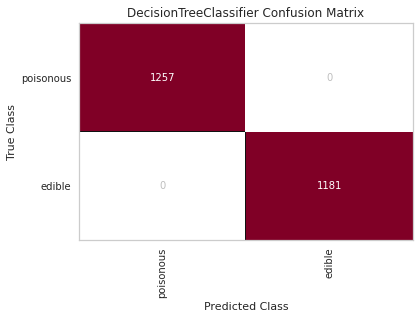

/home/matt/.envs/env36/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


ConfusionMatrix(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f35d50c2eb8>,
                classes=['poisonous', 'edible'],
                cmap=<matplotlib.colors.ListedColormap object at 0x7f3594d91908>,
                encoder=None, fontsize=None, force_model=False,
                is_fitted='auto', model=None, percent=False,
                sample_weight=None)

In [85]:
classifier.confusion_matrix(mush_dt, mush_X_train, mush_y_train, mush_X_test, mush_y_test,
                   classes=['poisonous', 'edible'])

/home/matt/.envs/env36/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


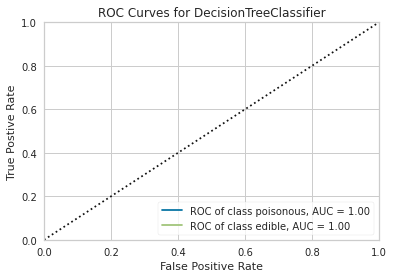

/home/matt/.envs/env36/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


ROCAUC(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f35d47daf98>,
       classes=['poisonous', 'edible'], encoder=None, force_model=False,
       is_fitted='auto', macro=False, micro=False, model=None, per_class=True)

In [87]:
classifier.roc_auc(mush_dt, mush_X_train, mush_y_train, mush_X_test, mush_y_test,
                   classes=['poisonous', 'edible'], micro=False, macro=False)